<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Модель-LinearRegression" data-toc-modified-id="Модель-LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель LinearRegression</a></span></li><li><span><a href="#Модель-RandomForestRegressor" data-toc-modified-id="Модель-RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель RandomForestRegressor</a></span></li><li><span><a href="#Модель-CatBoostRegressor" data-toc-modified-id="Модель-CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель CatBoostRegressor</a></span></li><li><span><a href="#Модель-LGBMRegressor" data-toc-modified-id="Модель-LGBMRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Модель LGBMRegressor</a></span></li><li><span><a href="#Сводная-результатов-обучения-моделей" data-toc-modified-id="Сводная-результатов-обучения-моделей-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Сводная результатов обучения моделей</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from math import sqrt
import time
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

In [2]:
# открытие файла с данными
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])
# изменение типа данных
df['datetime'] = df['datetime'].astype('datetime64')
# назначение нового индекса
df.set_index('datetime', inplace = True)
# сортировка индекса
df = df.sort_index()
# проверка на хронологический порядок
display(f'В хронологическом порядке ли индексы: {df.index.is_monotonic}')
# выведем таблицу
display(df.head())

'В хронологическом порядке ли индексы: True'

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Вывод

Таблицы открываются, пропусков в данных нет.

## Анализ

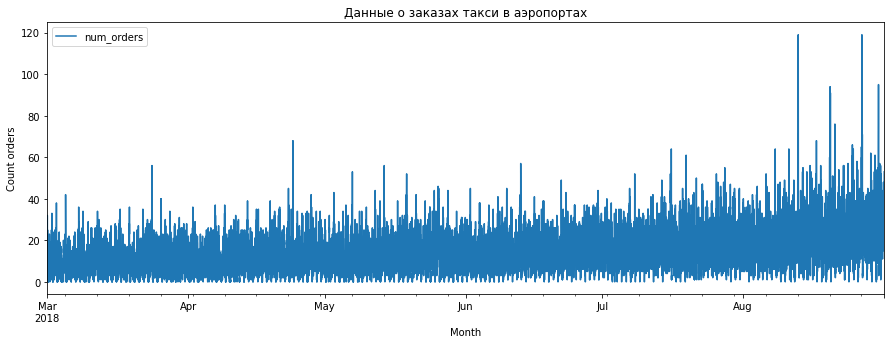

In [3]:
# посмотрим на данные в виде графика
df.plot(figsize=(15,5), xlabel='Month', ylabel='Count orders', title='Данные о заказах такси в аэропортах');

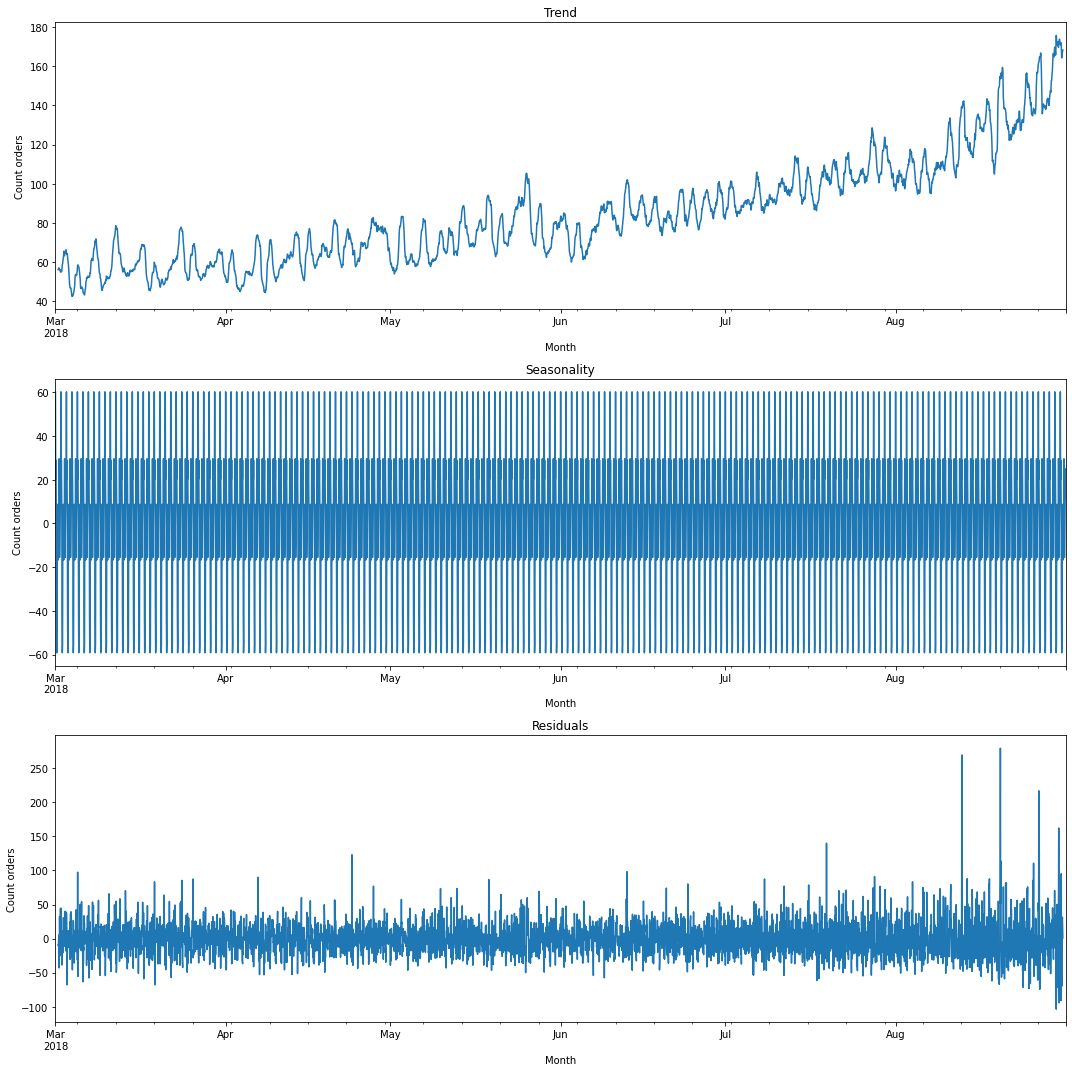

In [4]:
# сделаем ресемплирование по одному часу
data = df.resample('1H').sum()
# разложим таблицу с данными на тренды, сезонность и остаток
decomposed = seasonal_decompose(data)
# построим график трендов
plt.figure(figsize=(15, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Month')
plt.ylabel('Count orders')
# построим график сезонности
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.xlabel('Month')
plt.ylabel('Count orders')
# построим график остатков
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Month')
plt.ylabel('Count orders')
plt.tight_layout()

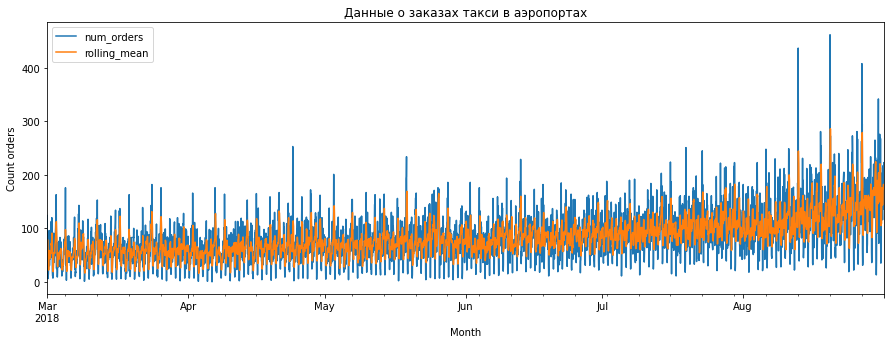

In [5]:
# вычислим скользящее среднее
data_roll = data.copy()
data_roll['rolling_mean'] = data_roll.rolling(5).mean() 
data_roll.plot(figsize=(15,5), xlabel='Month', ylabel='Count orders', title='Данные о заказах такси в аэропортах');

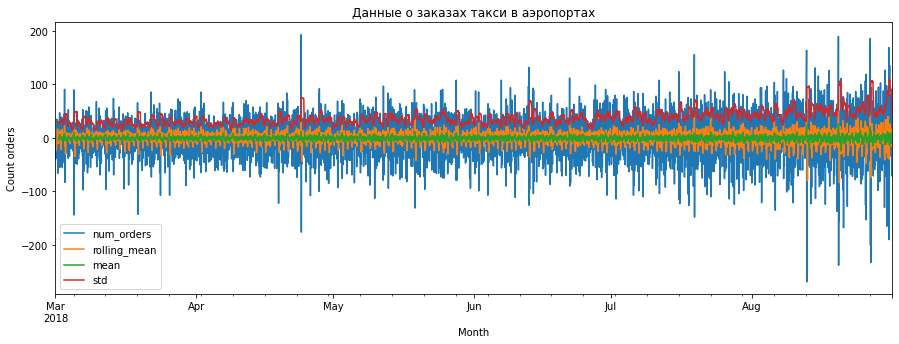

In [6]:
# добавим смещение
data_roll = data_roll - data_roll.shift()
# рассчитаем среднее и среднее отклонение
data_roll['mean'] = data_roll['num_orders'].rolling(15).mean()
data_roll['std'] = data_roll['num_orders'].rolling(15).std()
# построим обновленный график
data_roll.plot(figsize=(15,5), xlabel='Month', ylabel='Count orders', title='Данные о заказах такси в аэропортах');

### Вывод

- В начале каждого месяца наблюдается спад в 5 случаях из 6.
- Имеются восходящие тренды от начала месяца с кульминацией в 20х числах каждого месяца.
- За полгода количество заказов выросло вдвое.

## Обучение

### Подготовка данных

In [7]:
# сделаем ресемплирование по одному часу
data_ml = df.resample('1H').sum()
display(data_ml.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
# создадим функцию для подготовки признаков
def make_features(data, max_lag, rolling_mean_size):
    df_ml = data.copy()
    # признаки "календарные"
    df_ml['year'] = df_ml.index.year
    df_ml['month'] = df_ml.index.month
    df_ml['day'] = df_ml.index.day
    df_ml['dayofweek'] = df_ml.index.dayofweek
    # признаки "отстающих значений"
    for lag in range(1, max_lag + 1):
        df_ml['lag_{}'.format(lag)] = df_ml['num_orders'].shift(lag)
    # признаки "скользящего среднего"
    df_ml['rolling_mean'] = df_ml['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df_ml
# применим функцию к таблице
df_ml = make_features(data_ml, 25, 5)
# # выведем на экран
display(df_ml.head(6))

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,2018,3,1,3,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.8


In [9]:
# подготовим выборки
train, test = train_test_split(df_ml, shuffle=False, test_size=0.1)
train = train.dropna()
# train, valid = train_test_split(train, shuffle=False, test_size=0.112)
# обоначим признаки и цели в обучающей выборке
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)
# обоначим признаки и цели в валидационной выборке
# target_valid = valid['num_orders']
# features_valid = valid.drop('num_orders', axis=1)
# обоначим признаки и цели в тестовой выборке
target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)
# объединим выборки для использования в разделе 4
# features_train_max = pd.concat([features_train, features_valid])
# target_train_max = pd.concat([target_train, target_valid])
# выведем на экран
display(f'target_train {target_train.shape}')
display(f'features_train {features_train.shape}')
# display(f'target_valid {target_valid.shape}')
# display(f'features_valid {features_valid.shape}')
display(f'target_test {target_test.shape}')
display(f'features_test {features_test.shape}')

'target_train (3949,)'

'features_train (3949, 30)'

'target_test (442,)'

'features_test (442, 30)'

In [10]:
# введем функцию расчета rmse
def rmse_scorer(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)
rmse_score = make_scorer(rmse_scorer)

### Модель LinearRegression

In [11]:
%%time
start_0 = time.time()
### обучим модель LinearRegression для расчета RMSE
# параметры по сетке для подбора гиперпараметров с помощью GridSearchCV
parameters_0 = {
    'positive': ['True', 'False'], 
    'fit_intercept': ['True', 'False'] 
}
lin_reg0 = LinearRegression()
cv_0 = TimeSeriesSplit(n_splits=4)
clf_0 = GridSearchCV(lin_reg0, parameters_0, scoring=rmse_score, cv=cv_0, n_jobs=-1)
clf_0.fit(features_train, target_train)
score_0 = clf_0.best_score_
display(score_0)
display(clf_0.best_params_)

end_0 = time.time() - start_0

27.338658288710437

{'fit_intercept': 'True', 'positive': 'True'}

CPU times: user 377 ms, sys: 877 ms, total: 1.25 s
Wall time: 1.27 s


### Модель RandomForestRegressor

In [12]:
%%time
start_1 = time.time()
### обучим модель RandomForestRegressor для расчета RMSE
# параметры по сетке для подбора гиперпараметров с помощью GridSearchCV
parameters_1 = {
    'n_estimators': [100, 300], 
    'max_depth': [10, 20],
    'min_samples_split': [5, 10]
}
ran_for1 = RandomForestRegressor()
cv_1 = TimeSeriesSplit(n_splits=4)
clf_1 = GridSearchCV(ran_for1, parameters_1, scoring=rmse_score, cv=cv_1, n_jobs=-1)
clf_1.fit(features_train, target_train)
score_1 = clf_1.best_score_
display(score_1)
display(clf_1.best_params_)

end_1 = time.time() - start_1

26.59042033342871

{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}

CPU times: user 2min 9s, sys: 674 ms, total: 2min 10s
Wall time: 2min 10s


### Модель CatBoostRegressor

In [13]:
%%time
start_2 = time.time()
### обучим модель CatBoostRegressor для расчета RMSE
# параметры по сетке для подбора гиперпараметров с помощью GridSearchCV
parameters_2 = {
    'iterations': [1000, 2000], 
    'learning_rate': [0.01, 0.015],
    'depth': [5, 10]
}
cbr_2 = CatBoostRegressor(verbose=500)
cv_2 = TimeSeriesSplit(n_splits=4)
clf_2 = GridSearchCV(cbr_2, parameters_2, scoring=rmse_score, cv=cv_2, n_jobs=-1, verbose=3)
clf_2.fit(features_train, target_train)
score_2 = clf_2.best_score_
display(score_2)
display(clf_2.best_params_)

end_2 = time.time() - start_2

Fitting 4 folds for each of 8 candidates, totalling 32 fits
0:	learn: 29.3188359	total: 50.2ms	remaining: 50.1s
500:	learn: 15.5978380	total: 1.22s	remaining: 1.21s
999:	learn: 12.7094502	total: 2.36s	remaining: 0us
[CV 1/4] END ...depth=5, iterations=1000, learning_rate=0.01; total time=   3.3s
0:	learn: 30.8307419	total: 4.12ms	remaining: 4.11s
500:	learn: 17.3986103	total: 1.31s	remaining: 1.31s
999:	learn: 15.4331849	total: 2.56s	remaining: 0us
[CV 2/4] END ...depth=5, iterations=1000, learning_rate=0.01; total time=   3.4s
0:	learn: 32.7253487	total: 3.74ms	remaining: 3.73s
500:	learn: 18.9219455	total: 1.45s	remaining: 1.45s
999:	learn: 16.9516806	total: 2.84s	remaining: 0us
[CV 3/4] END ...depth=5, iterations=1000, learning_rate=0.01; total time=   3.7s
0:	learn: 34.1156215	total: 4.05ms	remaining: 4.05s
500:	learn: 20.4411433	total: 1.52s	remaining: 1.52s
999:	learn: 18.6194955	total: 3.12s	remaining: 0us
[CV 4/4] END ...depth=5, iterations=1000, learning_rate=0.01; total time=

26.555128562142954

{'depth': 10, 'iterations': 1000, 'learning_rate': 0.01}

CPU times: user 18min 44s, sys: 9.98 s, total: 18min 54s
Wall time: 19min 30s


### Модель LGBMRegressor

In [14]:
%%time
start_3 = time.time()
### обучим модель LGBMRegressor для расчета RMSE
# параметры по сетке для подбора гиперпараметров с помощью GridSearchCV
parameters_3 = {
    'n_estimators': [100, 200], 
    'learning_rate': [0.01, 0.015],
    'max_depth': [5, 10]
}
lgbm_reg3 = LGBMRegressor()
cv_3 = TimeSeriesSplit(n_splits=4)
clf_3 = GridSearchCV(lgbm_reg3, parameters_3, scoring=rmse_score, cv=cv_3, n_jobs=-1, verbose=3)
clf_3.fit(features_train, target_train)
score_3 = clf_3.best_score_
display(score_3)
display(clf_3.best_params_)

end_3 = time.time() - start_3

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV 1/4] END learning_rate=0.01, max_depth=5, n_estimators=100; total time= 1.4min
[CV 2/4] END learning_rate=0.01, max_depth=5, n_estimators=100; total time=   7.6s
[CV 3/4] END learning_rate=0.01, max_depth=5, n_estimators=100; total time=   6.6s
[CV 4/4] END learning_rate=0.01, max_depth=5, n_estimators=100; total time=   6.5s
[CV 1/4] END learning_rate=0.01, max_depth=5, n_estimators=200; total time=   8.2s
[CV 2/4] END learning_rate=0.01, max_depth=5, n_estimators=200; total time=   9.5s
[CV 3/4] END learning_rate=0.01, max_depth=5, n_estimators=200; total time=  17.4s
[CV 4/4] END learning_rate=0.01, max_depth=5, n_estimators=200; total time=  15.3s
[CV 1/4] END learning_rate=0.01, max_depth=10, n_estimators=100; total time=   5.9s
[CV 2/4] END learning_rate=0.01, max_depth=10, n_estimators=100; total time=   8.4s
[CV 3/4] END learning_rate=0.01, max_depth=10, n_estimators=100; total time=  16.1s
[CV 4/4] END learning_ra

31.311775121182002

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

CPU times: user 12min 6s, sys: 9.36 s, total: 12min 15s
Wall time: 12min 21s


### Сводная результатов обучения моделей

In [15]:
### выведем результаты как таблицу с данными
total_row_0 = ['rmse', score_0, score_1, score_2, score_3]
total_row_1 = ['time_learn', end_0, end_1, end_2, end_3]
data_temp_scores = pd.DataFrame([total_row_0, total_row_1])
data_temp_scores.columns = ['Metrics', 'LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor']
display(data_temp_scores.set_index('Metrics'))

,LinearRegression,RandomForestRegressor,CatBoostRegressor,LGBMRegressor
Metrics,,,,
rmse,27.338658,26.590420,26.555129,31.311775
time_learn,1.270045,130.751619,1170.258437,741.390131


### Вывод

По результатам обучения моделей:
- Лучший показатель у модели `CatBoostRegressor`, но с самым большим показателем временем обучения среди остальных моделей.
- У модели `RandomForestRegressor` почти самое быстрое время обучения, при близких к лучшему показателю метрики.
- У модели `LGBMRegressor`  среднее время обучения, при самом плохом показателе метрики.
- У модели  `LinearRegressor` самое быстрое время обучения, при очень хорошем показателе метрики.

## Тестирование

Цель: достигнуть значение метрики RMSE на тестовой выборке не больше 48

In [16]:
### обучим модель CatBoostRegressor для расчета RMSE на объединенной выборке
cbr_2t = CatBoostRegressor(iterations=1000, learning_rate=0.01, depth=10, verbose=500)
cbr_2t.fit(features_train, target_train)
predictions_2t = pd.DataFrame(cbr_2t.predict(features_test), index=target_test.index)
predictions_2t.columns = ['num_orders_pred']
target_test = pd.DataFrame(target_test)
target_test.columns = ['num_orders']
score_2t = sqrt(mean_squared_error(target_test, predictions_2t))
display(score_2t)

0:	learn: 38.5134213	total: 56.4ms	remaining: 56.3s
500:	learn: 18.4023139	total: 28.5s	remaining: 28.4s
999:	learn: 14.7701918	total: 56.7s	remaining: 0us


45.56375927512356

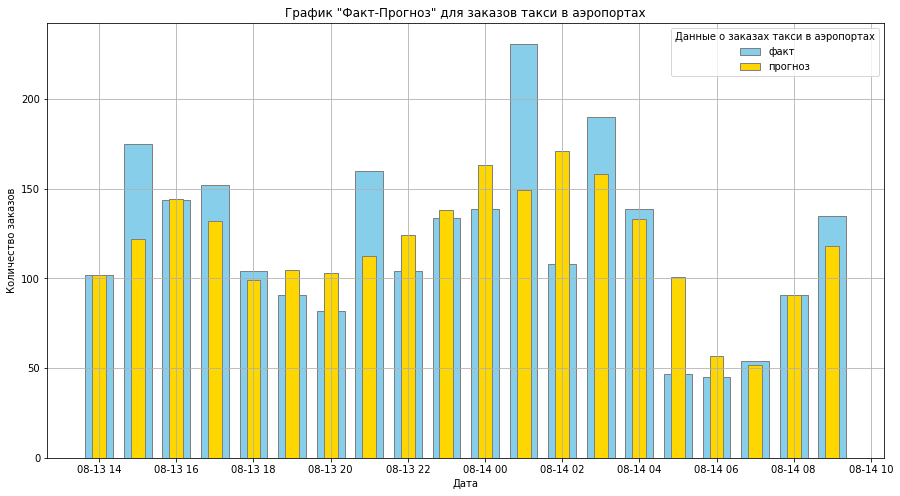

In [17]:
# построение графика "факт-прогноз" (для наглядности графика ограничимся первыми 20 строками)
fig1, ax1 = plt.subplots()
ax1.bar(target_test[0:20].index, target_test.num_orders[0:20], color = 'skyblue', edgecolor = 'grey', width = 0.03, label = 'факт')
ax1.bar(predictions_2t[0:20].index, predictions_2t.num_orders_pred[0:20], color = 'gold', edgecolor = 'grey', width = 0.015, label = 'прогноз')
fig1.set_figwidth(15)
fig1.set_figheight(8)
ax1.set_xlabel('Дата')
ax1.set_ylabel('Количество заказов')
plt.grid()
plt.legend(title='Данные о заказах такси в аэропортах')
plt.title('График "Факт-Прогноз" для заказов такси в аэропортах')
plt.show()

### Вывод

Цель достигнута, метрика `RMSE` составила 44,07 на тестовой выборке